In [118]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [119]:
torch.__version__

'1.10.0'

In [120]:
device

device(type='cuda', index=0)

In [121]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

# Question 1 

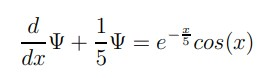

                      Ψ(0) = 0 and x ∈ [0, 2]

In [122]:
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

## Boundary conditions

In [123]:
A = 0 # Ψ(0)

## Trial solution

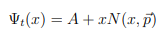

In [124]:
# approximator for 1st order ode, trial solution
def Psi_t(x): return A + x * N(x)

## Given IVP

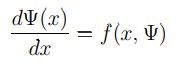

In [125]:
def f(x, Psi): return torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

## Loss function

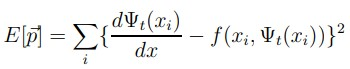

In [126]:
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),create_graph=True)[0]
    return  torch.mean((Psi_t_x - f(x, outputs))**2)

In [127]:
optimizer = torch.optim.LBFGS(N.parameters())

In [128]:
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

In [129]:
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()  
    return l

for i in range(10):
    optimizer.step(closure)

Text(0, 0.5, 'Ψ(x)')

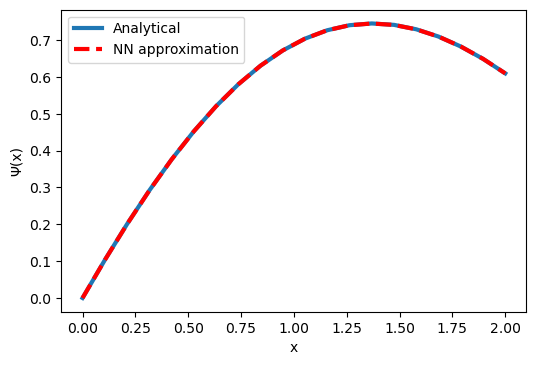

In [130]:
x = np.linspace(0, 2, 100)[:, None]

with torch.no_grad():
    y_predicted = Psi_t(torch.Tensor(x)).numpy()
    
y_true = np.exp(-x / 5.0) * np.sin(x)

fig, ax = plt.subplots(dpi=100)
ax.plot(x, y_true, label='Analytical',lw=3.0)
ax.plot(x, y_predicted, '--', label='NN approximation', color='r',lw=3.0)
plt.legend(loc=0)
ax.set_xlabel("x")
ax.set_ylabel("Ψ(x)")

# Question 2

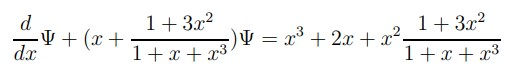


                            Ψ(0) = 1 and x ∈ [0, 1]

In [131]:
A = 1

In [132]:
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

In [133]:
def f(x, Psi): return (x**3 + 2*x + x**2*(1+3*x**2) /
                       (1+x+x**3) - Psi*(x + (1+3*x**2)/(1+x+x**3)))

In [134]:
def Psi_t(x): return A + x * N(x)

In [135]:
optimizer = torch.optim.LBFGS(N.parameters())

In [136]:
x = torch.Tensor(np.linspace(0, 1, 100)[:, None])

In [137]:
for i in range(10):
    optimizer.step(closure)

Text(0, 0.5, 'Ψ(x)')

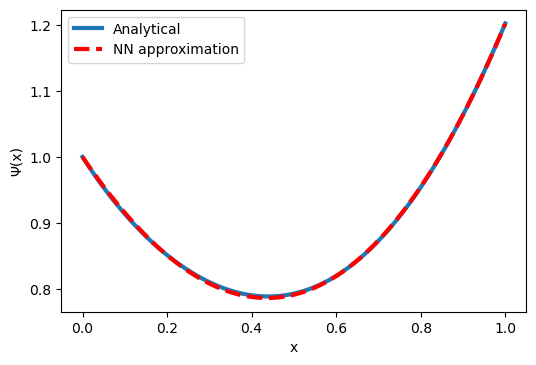

In [138]:
x = np.linspace(0, 1, 100)[:, None]

with torch.no_grad():
    y_predicted = Psi_t(torch.Tensor(x)).numpy()
    
y_true = (np.exp(-x**2 / 2.0)/(1+x+x**3)) + x**2

fig, ax = plt.subplots(dpi=100)
ax.plot(x, y_true, label='Analytical',lw=3)
ax.plot(x, y_predicted, '--', label='NN approximation', color='r',lw=3)
plt.legend(loc=0)
ax.set_xlabel("x")
ax.set_ylabel("Ψ(x)")

# Question 3

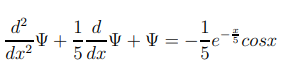

                        Ψ(0) = 1, dΨ(0)/dx = 1, x ∈ [0, 2]

In [139]:
A = 0 # Ψ(0)
B = 1 # dΨ(0)/dx

In [140]:
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

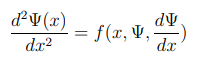

In [141]:
def f(x, Psi, Psi_x): 
    return -torch.exp(-x / 5) * torch.cos(x)/5 - Psi - Psi_x/5

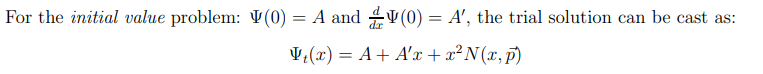

In [142]:
def Psi_t(x): 
    return A + B*x + x**2 * N(x)

In [143]:
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),create_graph=True)[0]
    Psi_t_x_x = torch.autograd.grad(Psi_t_x, x, grad_outputs=torch.ones_like(Psi_t_x),create_graph=True )[0]

    return torch.mean((Psi_t_x_x - f(x, outputs, Psi_t_x)) ** 2)

In [144]:
optimizer = torch.optim.LBFGS(N.parameters())

In [145]:
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

In [146]:
for i in range(10):
    optimizer.step(closure)

Text(0, 0.5, 'Ψ(x)')

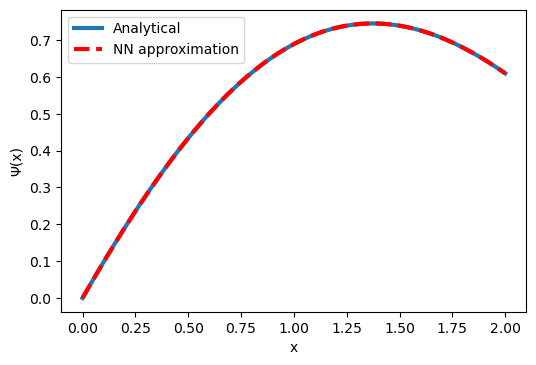

In [147]:
x = np.linspace(0, 2, 100)[:, None]

with torch.no_grad():
    y_predicted = Psi_t(torch.Tensor(x)).numpy()
    
y_true = np.exp(-x/5)*np.sin(x)

fig, ax = plt.subplots(dpi=100)
ax.plot(x, y_true, label='Analytical',lw=3.0)
ax.plot(x, y_predicted, '--', label='NN approximation', color='r',lw=3.0)
plt.legend(loc=0)
ax.set_xlabel("x")
ax.set_ylabel("Ψ(x)")

# Question 4

                    Ψ(0) = 1, Ψ(1) = sin(1)*e^(-1/5), x ∈ [0, 1]

In [148]:
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

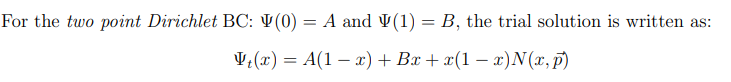

In [149]:
A = 0
B = np.sin(1)*np.exp(-1/5)

In [150]:
def Psi_t(x): 
    return A*(1-x) + B * x + (1-x) * x * N(x)

In [151]:
def f(x, Psi, Psi_x): 
    return -torch.exp(-x / 5) * torch.cos(x)/5 - Psi - Psi_x/5

In [152]:
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)

    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                            create_graph=True)[0]
    Psi_t_x_x = torch.autograd.grad(Psi_t_x, x, grad_outputs=torch.ones_like(Psi_t_x),
                                            create_graph=True )[0]

    return torch.mean((Psi_t_x_x - f(x, outputs, Psi_t_x)) ** 2)

In [153]:
optimizer = torch.optim.LBFGS(N.parameters())

In [154]:
x = torch.Tensor(np.linspace(0, 1, 100)[:, None])

In [155]:
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l

for i in range(10):
    optimizer.step(closure)

Text(0, 0.5, 'Ψ(x)')

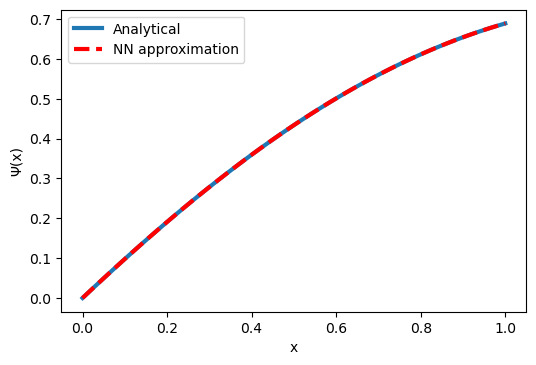

In [156]:
x = np.linspace(0, 1, 100)[:, None]

with torch.no_grad():
    y_predicted = Psi_t(torch.Tensor(x)).numpy()
    
y_true = np.exp(-x/5)*np.sin(x)

fig, ax = plt.subplots(dpi=100)
ax.plot(x, y_true, label='Analytical',lw=3.0)
ax.plot(x, y_predicted, '--', label='NN approximation', color='r',lw=3.0)
plt.legend(loc=0)
ax.set_xlabel("x")
ax.set_ylabel("Ψ(x)")